In [1]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 8.7 MB/s eta 0:00:0000:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.3/426.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.14.1
    Uninstalling huggingface-hub-0.14.1:
      Successfully uninstalled huggingface-hub-0.14.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.1
    Uninsta

In [4]:
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import yaml

In [5]:
with open(r"./t-sne_configs.yml") as file:
    params_list = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n):
        yield l[i : i + n]

def get_embeddings(model, vectors, bs=20):
    embeddings = []
    for batch in tqdm(divide_chunks(vectors, bs), position=0, leave=True):
        result = model.encode(batch, show_progress_bar=False)
        embeddings.extend(result)
    
    return embeddings

def pca_tsne(model, set_name, preds, gold):
    pred1, pred2 = map(list, zip(*preds))
    golds = []
    for elem in gold:
        golds.append(', '.join(elem['parents']))

    gold_emb = get_embeddings(model, golds)
    pred1_emb, pred2_emb = get_embeddings(model, pred1), get_embeddings(model, pred2)
    
    all_emb = gold_emb + pred1_emb + pred2_emb
    number = len(gold_emb)
    labels = ['gold']*number + ['pred_1']*number + ['pred_2']*number
    
    X = np.array(all_emb)
    X = PCA(n_components=25, svd_solver='full').fit_transform(X)
    X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)
    
    df = pd.DataFrame(data=X_embedded, columns=['Component 1', 'Component 2'])
    df['Class'] = labels

    # Create a Scatter Plot with Seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Component 1', y='Component 2', hue='Class', palette="magma", data=df)

    plt.title(f'{set_name} t-SNE Visualization')
    plt.savefig(f"{set_name}_tsne.png")
    plt.show()
    

./t-sne_data/scatters


75it [00:08,  8.78it/s]
75it [00:02, 32.08it/s]
75it [00:02, 33.84it/s]


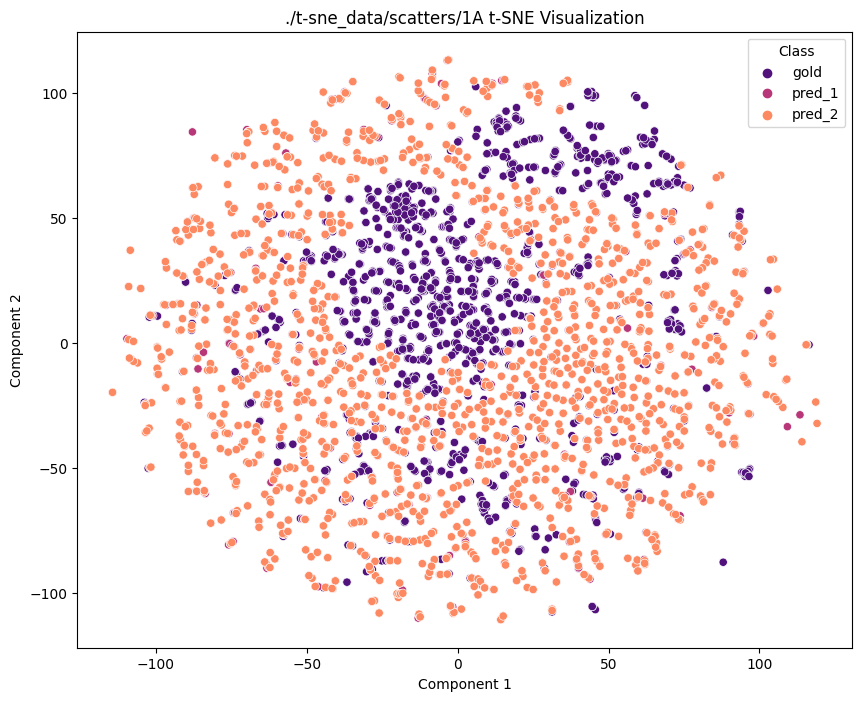

50it [00:02, 18.69it/s]
50it [00:01, 37.25it/s]
50it [00:00, 54.24it/s]


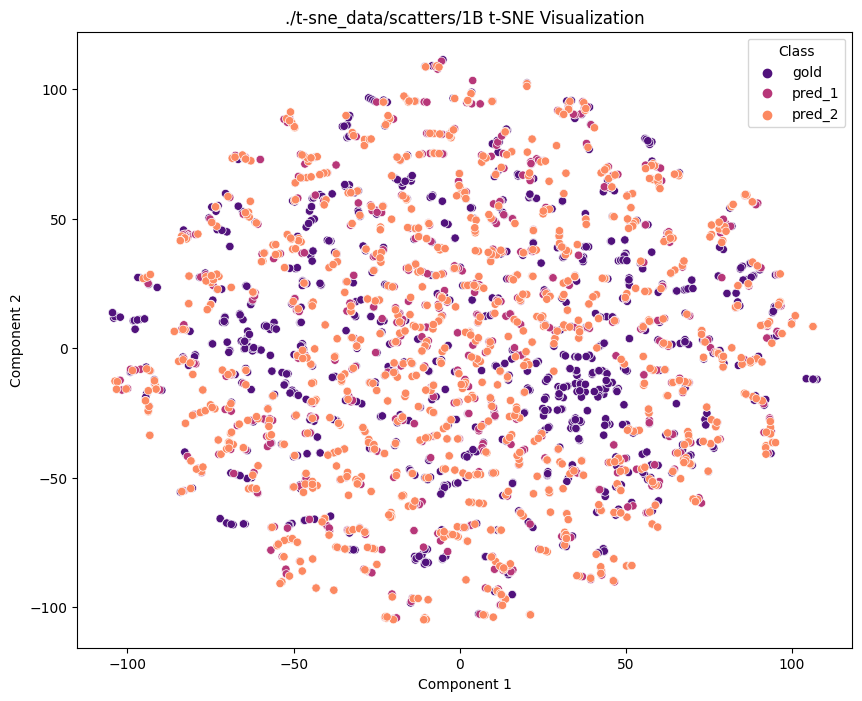

50it [00:03, 15.62it/s]
50it [00:00, 50.84it/s]
50it [00:01, 49.56it/s]


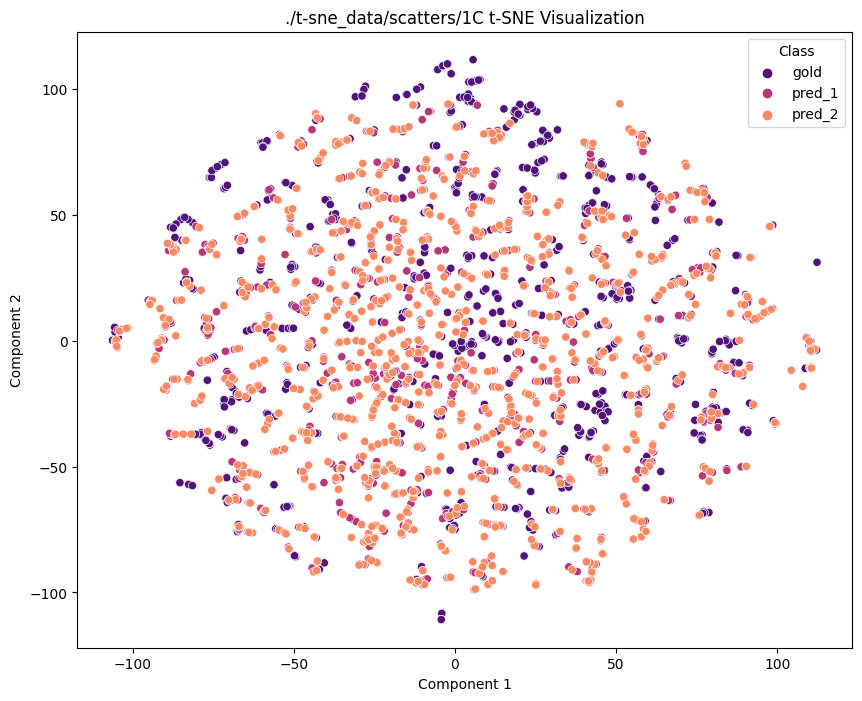

25it [00:02,  8.84it/s]
25it [00:00, 51.08it/s]
25it [00:00, 52.31it/s]


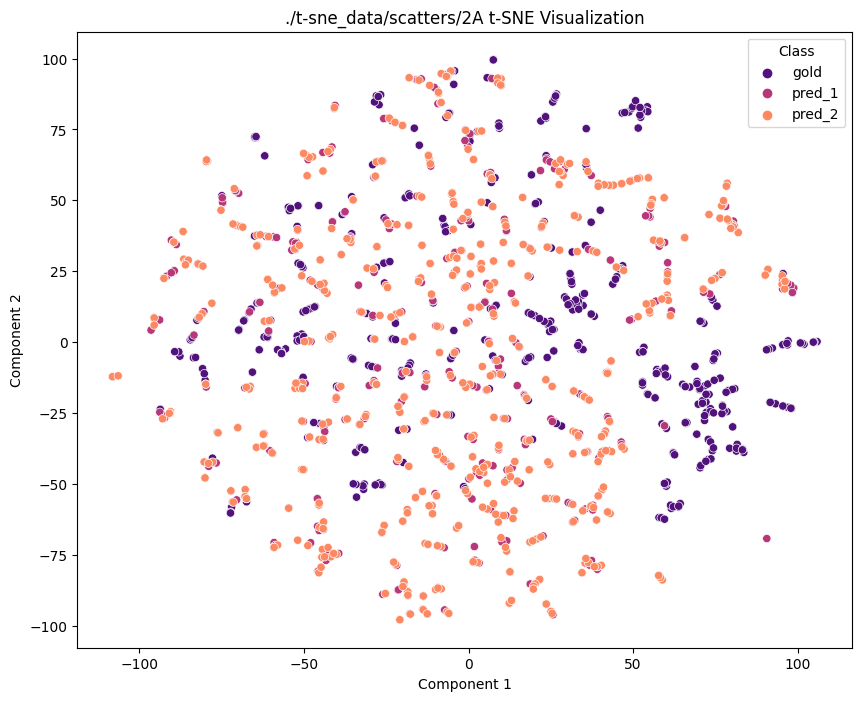

25it [00:02, 11.20it/s]
25it [00:00, 49.93it/s]
25it [00:00, 51.68it/s]


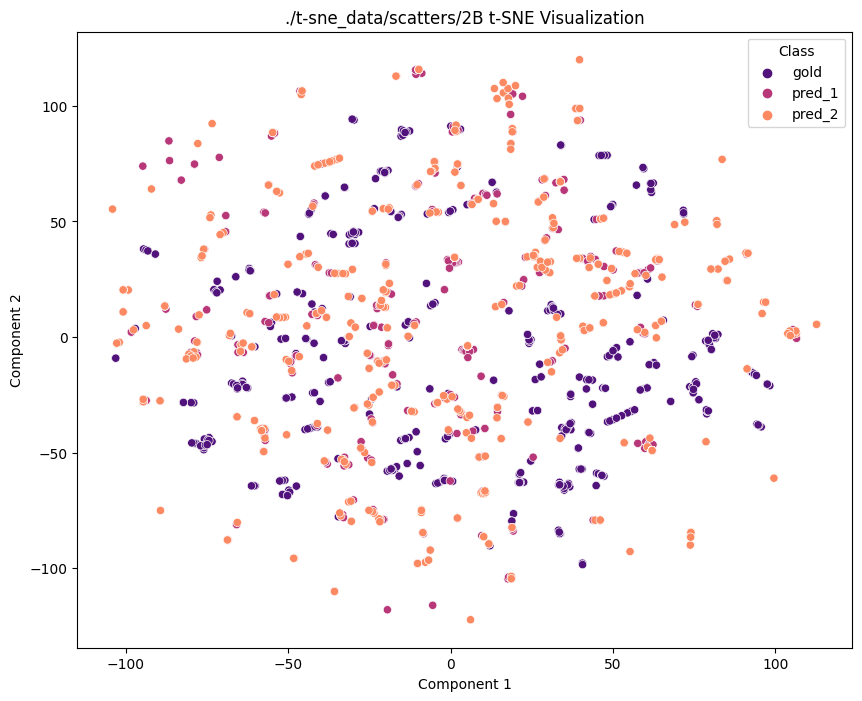

In [9]:
set_names = ['1A', '1B', '1C', '2A', '2B']
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
indir = params_list['DATA_DIR'][0]
outdir  = params_list['OUT_DIR'][0]
print(outdir)

if not os.path.exists(outdir):
    os.mkdir(outdir)


for name in set_names:
    matches = [f'{indir}/{x}' for x in os.listdir(indir) if name in x]
    for file in matches:
        if '.pickle' in file:
            gold = pickle.load(open(file, 'rb'))
        else:
            preds = pickle.load(open(file, 'rb'))
            
    pca_tsne(model, f'{outdir}/{name}', preds, gold)